In [112]:
'''
http://skyserver.sdss.org/dr13/en/help/browser/browser.aspx#&&history=description+PhotoObj+V
SELECT
p.ra AS ra,
p.dec AS dec,
p.flags,
p.type,
Photoz.z AS Photz,
Photoz.zErr AS PhotzErr,
SpecObj.z As Specz,
SpecObj.zErr As SpeczErr,
SpecObj.zWarning As zWarning,
SpecObj.class As SpecClass,
SpecObj.subClass As SpecsubClass,
p.u,
p.g,
p.r,
p.i,
p.z,
p.probPSF,
p.lnLStar_u,
p.lnLStar_g,
p.lnLStar_r,
p.lnLStar_i,
p.lnLStar_z,
p.probPSF_u,
p.probPSF_g,
p.probPSF_r,
p.probPSF_i,
p.probPSF_z
FROM PhotoObj AS p
LEFT JOIN Photoz  ON p.objID=Photoz.objID
LEFT JOIN SpecObj On p.specObjID = SpecObj.specObjID
WHERE
(p.ra BETWEEN 215.9 AND 218.6) 
AND
(p.dec BETWEEN 32.1 AND 34.3)
'''
clear_output()

In [3]:
import astropy.io.fits as fits
import astropy.wcs as wcs
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky

def add_xy(field, df):
    order = [c for c in df.columns]
    # find the x, y solution with all quad
    for inst in [1,2]:
        hdrdir = '/Users/ytcheng/ciber/doc/20170617_Stacking/maps/astroutputs/inst' + str(inst) + '/'
        xoff = [0,0,512,512]
        yoff = [0,512,0,512]
        for iquad,quad in enumerate(['A','B','C','D']):
            hdulist = fits.open(hdrdir + field + '_' + quad + '_astr.fits')
            wcs_hdr=wcs.WCS(hdulist[('primary',1)].header, hdulist)
            hdulist.close()
            src_coord = SkyCoord(ra=df['ra']*u.degree, dec=df['dec']*u.degree, frame='icrs')

            x_arr, y_arr = wcs_hdr.all_world2pix(df['ra'],df['dec'],0)
            df['x' + quad] = x_arr + xoff[iquad]
            df['y' + quad] = y_arr + yoff[iquad]

        df['meanx'] = (df['xA'] + df['xB'] + df['xC'] + df['xD']) / 4
        df['meany'] = (df['yA'] + df['yB'] + df['yC'] + df['yD']) / 4

        # assign the x, y with the nearest quad solution
        df['x'+str(inst)] = df['xA'].copy()
        df['y'+str(inst)] = df['yA'].copy()
        bound = 511.5
        df.loc[ (df['meanx'] < bound) & (df['meany'] > bound),'x'+str(inst)] = df['xB']
        df.loc[ (df['meanx'] < bound) & (df['meany'] > bound),'y'+str(inst)] = df['yB']
        
        df.loc[ (df['meanx'] > bound) & (df['meany'] < bound),'x'+str(inst)] = df['xC']
        df.loc[ (df['meanx'] > bound) & (df['meany'] < bound),'y'+str(inst)] = df['yC']

        df.loc[ (df['meanx'] > bound) & (df['meany'] > bound),'x'+str(inst)] = df['xD']
        df.loc[ (df['meanx'] > bound) & (df['meany'] > bound),'y'+str(inst)] = df['yD']

    # write x, y to df
    order = order[:2] + ['x1','y1','x2','y2'] + order[2:]
    dfout = df[order].copy()
    
    return dfout

In [ ]:
ifield = 6
field = 'BootesB'
fname = '/Users/ytcheng/Downloads/BootesB.csv'

f = open(fname)
wdfname = f.readlines()[1].strip().split(',')
f.close()

df = pd.read_csv(fname, skiprows = 2,\
                   names = wdfname, low_memory = False) 

df = df[df['type']==6]
df = add_xy(field,df)
df = df[(df['x1']>-0.5) & (df['y1']>-0.5) & (df['x1']<1023.5) & (df['y1']<1023.5)]
df['profPSF_tot'] = df[['probPSF_u','probPSF_g','probPSF_r','probPSF_i','probPSF_z']].sum(axis=1)
df5 = df[df['profPSF_tot']==5]
df0 = df[df['profPSF_tot']!=5]

In [20]:
from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}

cbmap, strmask, strnum, mask_inst = \
load_processed_images(data_maps, return_names=[(inst,ifield,'cbmap'), 
                                   (inst,ifield,'strmask'), 
                                   (inst,ifield,'strnum'),
                                  (inst,ifield,'mask_inst')])

In [114]:
from stack_ancillary import *

inst = 1
Nstack = 300
m_min_arr = np.arange(14,20)
m_max_arr = m_min_arr + 1
stackdat_dict = {}
stackdat_dict['Nmax'] = Nstack
stackdat_dict['profPSF5'] = {}
stackdat_dict['profPSF0'] = {}
stackdat_dict['m_min_arr'] = m_min_arr
stackdat_dict['m_max_arr'] = m_max_arr

for im, (m_min, m_max) in enumerate(zip(m_min_arr, m_max_arr)):
    xls = np.array(df0['y1'][(df0['z']>m_min) & (df0['z']<m_max)])
    yls = np.array(df0['x1'][(df0['z']>m_min) & (df0['z']<m_max)])
    stackdat_dict['profPSF0'][im] = {}
    stackdat_dict['profPSF0'][im]['Nsrc'] = len(xls)
    if len(xls) > Nstack:
        sp = np.random.choice(len(xls),Nstack,replace=False)
        xls, yls = xls[sp], yls[sp]
    stack_class = stacking_mock(inst, m_min, m_max)
    stack_class.xls = xls
    stack_class.yls = yls
    print('stack %d < m < %d, %s src, profPSF0'%(m_min, m_max, len(xls)))
    if len(xls) > 0:
        stackdat = stack_class.run_stacking\
        (cbmap, strmask, strnum, mask_inst=mask_inst)
        stackdat_dict['profPSF0'][im]['stackdat'] = stackdat

    xls = np.array(df5['y1'][(df5['z']>m_min) & (df5['z']<m_max)])
    yls = np.array(df5['x1'][(df5['z']>m_min) & (df5['z']<m_max)])
    stackdat_dict['profPSF5'][im] = {}
    stackdat_dict['profPSF5'][im]['Nsrc'] = len(xls)
    if len(xls) > Nstack:
        sp = np.random.choice(len(xls),Nstack,replace=False)
        xls, yls = xls[sp], yls[sp]
    stack_class = stacking_mock(inst, m_min, m_max)
    stack_class.xls = xls
    stack_class.yls = yls
    print('stack %d < m < %d, %s src, profPSF5'%(m_min, m_max, len(xls)))
    if len(xls) > 0:
        stackdat = stack_class.run_stacking\
        (cbmap, strmask, strnum, mask_inst=mask_inst)
        stackdat_dict['profPSF5'][im]['stackdat'] = stackdat
clear_output()

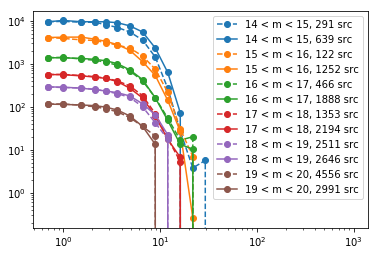

In [155]:
Nstack = stackdat_dict['Nmax']
m_min_arr = stackdat_dict['m_min_arr']
m_max_arr = stackdat_dict['m_max_arr']

for im, (m_min, m_max) in enumerate(zip(m_min_arr, m_max_arr)):
    stackdat = stackdat_dict['profPSF0'][im]['stackdat'] 
    Nsrc = stackdat_dict['profPSF0'][im]['Nsrc']
    plt.loglog(stackdat['rbins'], stackdat['prof'],'o--',c='C'+str(im),label='%d < m < %d, %d src'%(m_min, m_max, Nsrc))
    norm = stackdat['prof'][0]
    stackdat = stackdat_dict['profPSF5'][im]['stackdat'] 
    Nsrc = stackdat_dict['profPSF5'][im]['Nsrc']
    norm = norm / stackdat['prof'][0]
    plt.loglog(stackdat['rbins'], stackdat['prof']*norm,'o-',c='C'+str(im),
               label='%d < m < %d, %d src'%(m_min, m_max, Nsrc))

plt.legend()

(0.5, 10)

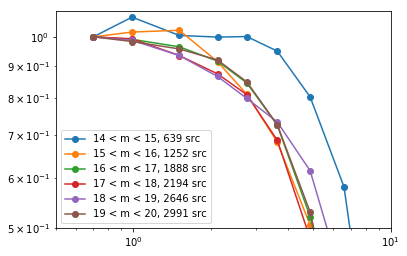

In [160]:
Nstack = stackdat_dict['Nmax']
m_min_arr = stackdat_dict['m_min_arr']
m_max_arr = stackdat_dict['m_max_arr']

for im, (m_min, m_max) in enumerate(zip(m_min_arr, m_max_arr)):
    stackdat = stackdat_dict['profPSF0'][im]['stackdat'] 
    Nsrc = stackdat_dict['profPSF0'][im]['Nsrc']
#     plt.loglog(stackdat['rbins'], stackdat['prof']/stackdat['prof'][0],'o--',c='C'+str(im),label='%d < m < %d, %d src'%(m_min, m_max, Nsrc))
    norm = stackdat['prof'][0]
    stackdat = stackdat_dict['profPSF5'][im]['stackdat'] 
    Nsrc = stackdat_dict['profPSF5'][im]['Nsrc']
    norm = norm / stackdat['prof'][0]
    plt.loglog(stackdat['rbins'], stackdat['prof']/stackdat['prof'][0],'o-',c='C'+str(im),
               label='%d < m < %d, %d src'%(m_min, m_max, Nsrc))

plt.legend()
plt.ylim([0.5,1.1])
plt.xlim([0.5,10])

# GAIA

In [228]:
# # processing GAIA data
# from utils import *
# for ifield in [4,5,6,7,8]:
#     catdir = '/Users/ytcheng/ciber/doc/20170617_Stacking/maps/gaiacats/'
#     catcoorddir = '/Users/ytcheng/ciber/doc/20170617_Stacking/maps/catcoord/'

#     df = pd.read_csv(catdir + fieldnamedict[ifield] + '.csv')
#     df = catalog_add_xy_from_radec(fieldnamedict[ifield], df)
#     df = df[['ra','dec','x1', 'y1', 'x2', 'y2','parallax','phot_g_mean_mag']].copy()
#     fname = catcoorddir + 'GAIA/' + fieldnamedict[ifield] + '.csv'
#     df.to_csv(fname, index=False)

In [1]:
from reduction import *
data_maps = {1: image_reduction(1), 2: image_reduction(2)}

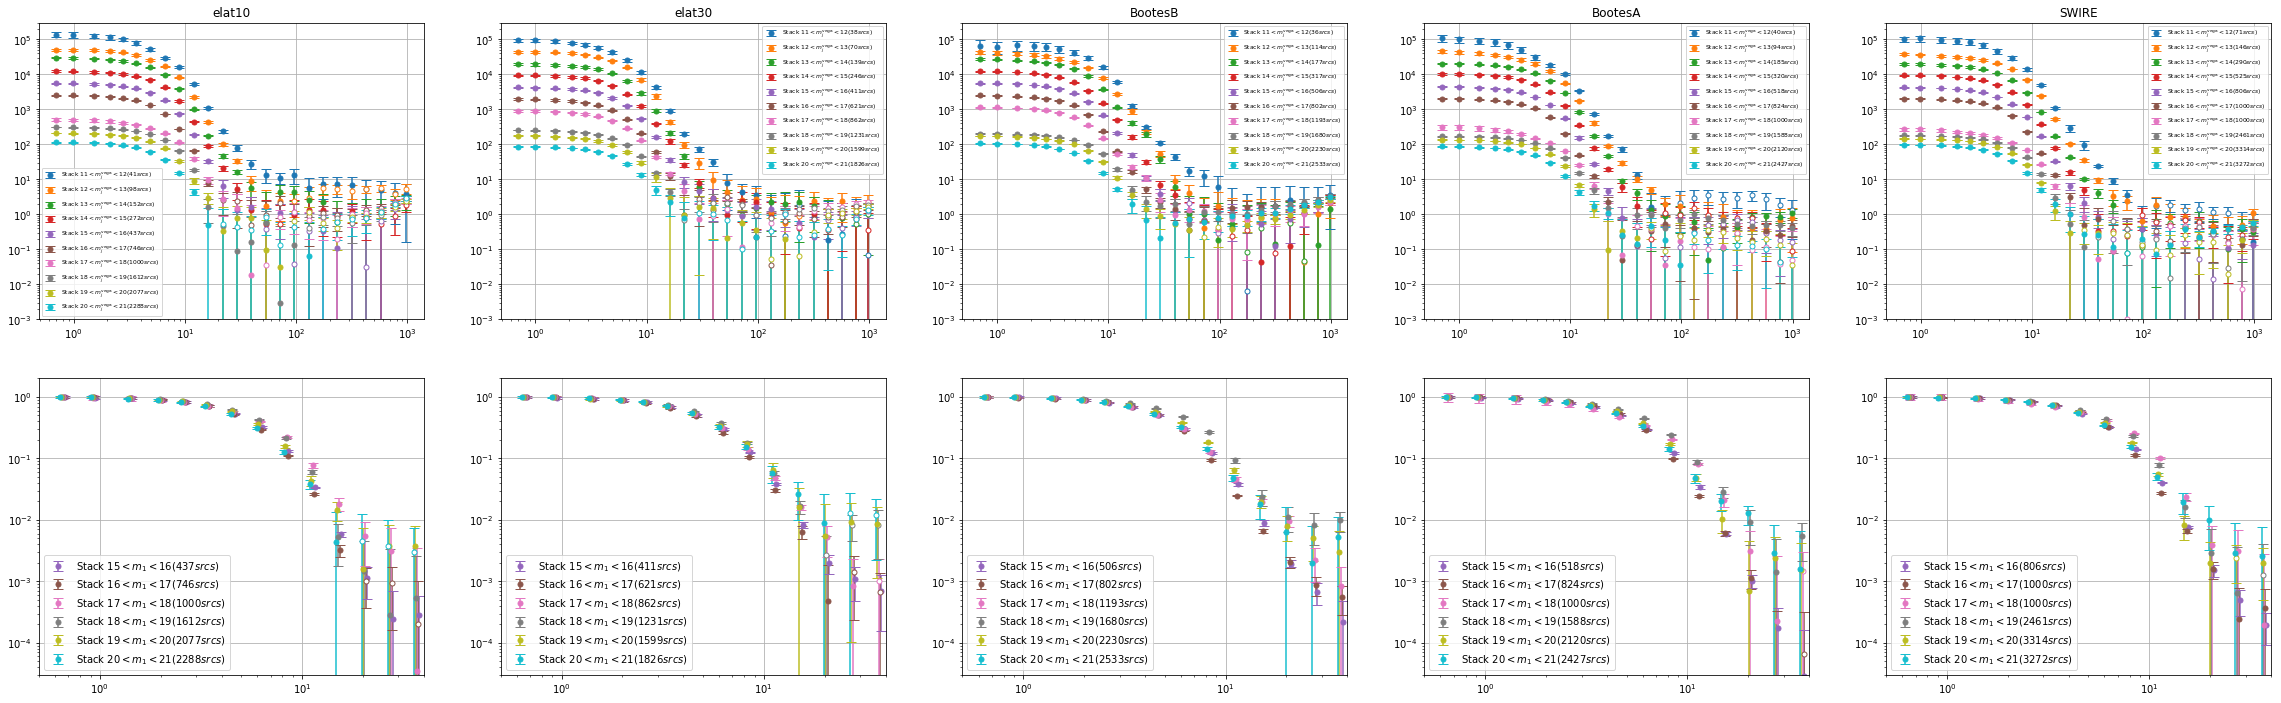

In [5]:
from psfsynth import *
# from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}

psfmodel ={}
inst = 1
profc = np.zeros(25)
fig, ax = plt.subplots(2, 5, figsize = (40,12))
for i, ifield in enumerate([4,5,6,7,8]):
    for im,(m_min, m_max) in enumerate(zip(np.arange(11,21), np.arange(12,22))):
        fname = mypaths['alldat'] + 'TM'+ str(inst) +\
         '/psfdata_synth_gaia_%s_%d_%d.pkl'%(fieldnamedict[ifield],m_min, m_max)
        with open(fname, "rb") as f:
            profdat = pickle.load(f)
        plot_err_log(profdat['rbins'], 
                     profdat['profcb'],
                     profdat['profcb_err'], plot_xerr=False,
                     ax=ax[0][i], color='C'+str(im),
                     label=r'Stack $%d < m_j^{\rm vega} <%d (%d srcs)$'%(m_min, m_max, profdat['Nsrc']))
        if m_min > 14:
            plot_err_log(profdat['rbins']*(1-im*0.01), 
                         profdat['profcb']/profdat['profcb'][0],
                         profdat['profcb_err']/profdat['profcb'][0],
                         ax=ax[1][i], color='C'+str(im), plot_xerr=False,
                         label=r'Stack $%d < m_1 <%d (%d srcs)$'%(m_min, m_max,profdat['Nsrc']))

        
    ax[0][i].set_title(fieldnamedict[ifield])
    ax[0][i].legend(fontsize=6)
    ax[0][i].set_ylim([1e-3,3e5])
    ax[1][i].legend()
    ax[0][i].grid()
    ax[1][i].grid()
    ax[1][i].set_ylim([3e-5,2])
    ax[1][i].set_xlim([5e-1,40])
#     plt.savefig('/Users/ytcheng/Desktop/star_stack.png', dpi = 100, bbox_inches='tight')

In [ ]:

run_psf_synth_mag_all_gaia(1,6, [20],[21])
run_psf_synth_mag_all_gaia(1,7, [20],[21])
run_psf_synth_mag_all_gaia(1,8, [20],[21])

In [1]:
from reduction import *
data_maps = {1: image_reduction(1), 2: image_reduction(2)}

In [6]:
from psfsynth import *

profdat = stack_gaia(1,5, data_maps=data_maps, m_min=17, m_max=18)